### Combining echos, misfit of exponential decay, highpass filtering
The drifts in the individual echos of the ME data are unfortunately not the same. This becomes an issue when combining the echos: exponential decay functions clearly don't fit if the drifts are uncorrelated (or the T2*-estimates can be biased greatly).

Therefore, apply a highpass filter to the individual echos *before* combination. The argumentation behind this step is that BOLD-responses have a much higher frequency than these slow drifts. Variability removed from the echos by highpass filtering (at 1/128 Hz) can therefore not be caused by BOLD-responses.

In [1]:
import nilearn
import nistats
import os
import pandas
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pprint import pprint
from nilearn.input_data import NiftiMasker
from nilearn.signal import butterworth
import json

from nilearn import plotting
%matplotlib inline

/home/stevenm/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/plotting/__init__.py:20: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')
/home/stevenm/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


### Echo combination without highpass filtering
Makes use of the "optimal combination" method (Posse et al., 1999)

### Highpass the preprocessed functional data

Highpass per echo separately

In [42]:
from nilearn.input_data import NiftiMasker

def high_pass(subject, session, run, echo=1, space='MNI152NLin2009cAsym', root_dir='./data/deriv/fmriprep', overwrite=False, verbose=False):
    # find fns
    if session == 'se':
        mask_fn = 'sub-{subject}/ses-se/func/sub-{subject}_ses-se_task-stop_run-{run}_space-{space}_desc-brain_mask.nii.gz'.format(**locals())
        bold_fn = 'sub-{subject}/ses-se/func/sub-{subject}_ses-se_task-stop_run-{run}_space-{space}_desc-preproc_bold.nii.gz'.format(**locals())
    else:
        mask_fn = 'sub-{subject}/ses-me/func/sub-{subject}_ses-me_task-stop_run-{run}_echo-{echo}_space-{space}_desc-brain_mask.nii.gz'.format(**locals())
        bold_fn = 'sub-{subject}/ses-me/func/sub-{subject}_ses-me_task-stop_run-{run}_echo-{echo}_space-{space}_desc-preproc_bold.nii.gz'.format(**locals())
        
    bold_fn = os.path.join(root_dir, bold_fn)
    mask_fn = os.path.join(root_dir, mask_fn)
    out_fn = bold_fn.replace('preproc_bold', 'preproc-hp_bold')
    
    if os.path.exists(out_fn) and not overwrite:
        print('Output file {} already exists'.format(out_fn))
        return 0
    if not os.path.exists(bold_fn):
        print('Theres no file named {}...'.format(bold_fn))
        return 0
    print('Highpass-filtering {}'.format(bold_fn))

    # Generate & fit NiftiMasker
    hp_masker = NiftiMasker(mask_img = mask_fn, high_pass=1./128, t_r=3)
    hp_data = hp_masker.fit_transform(bold_fn)

    # back to brain space
    inver = hp_masker.inverse_transform(hp_data)

    # add mean of timeseries per voxel back
    highpassed_data = inver.get_data() + np.mean(nib.load(bold_fn).get_data(), 3)[:,:,:,np.newaxis]
    highpassed_img = nib.Nifti1Image(highpassed_data, inver.affine)
    
    # save
    nib.save(highpassed_img, filename=out_fn)
    return out_fn
    
#high_pass('01', 'se', 1)

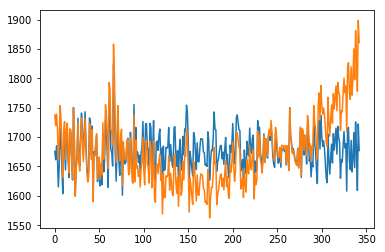

In [9]:
# hdr_hp = nib.load('./data/deriv/fmriprep/sub-01/ses-se/func/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz')
# plt.plot(hdr_hp.get_data()[50,50,50,:])
# hdr_nohp = nib.load('./data/deriv/fmriprep/sub-01/ses-se/func/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
# plt.plot(hdr_nohp.get_data()[50,50,50,:])

In [40]:
import itertools
import multiprocessing as mp
from functools import partial

def multiproc_hp_worker(to_run):
    print(to_run)
    
    if len(to_run) == 2:
        subject, run = to_run
        ses = 'se'
        echo = None # does nothing
    else:
        subject, run, echo = to_run
        ses = 'me'
        if subject == 12:
            return 0
    
    subject = str(subject).zfill(2)
    
    out_fn = high_pass(subject, session=ses, run=run, echo=echo, verbose=True)
    return out_fn

In [43]:
ses_se = list(itertools.product(np.arange(1,19), [1,2,3]))
ses_me = list(itertools.product(np.arange(1,19), [1,2,3], [1,2,3]))
to_run = ses_se + ses_me

with mp.Pool(10) as p:
    p.map(multiproc_hp_worker, to_run)

(7, 1)
(3, 1)
(1, 1, 1)
(5, 1)
(15, 1)
(9, 1)
(1, 1)
(13, 1)
(17, 1)
(11, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Output file ./data/deriv/fmriprep/sub-17/ses-se/func/sub-17_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz already exists
Output file ./data/deriv/fmriprep/sub-05/ses-se/func/sub-05_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz already exists
Output file ./data/deriv/fmriprep/sub-07/ses-se/func/sub-07_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz already exists
Output file ./data/deriv/fmriprep/sub-11/ses-se/func/sub-11_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz already exists
Output file ./data/deriv/fmriprep/sub-03/ses-se/func/sub-03_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz already exists
Output file ./d

(3, 1, 1)
Output file ./data/deriv/fmriprep/sub-06/ses-se/func/sub-06_ses-se_task-stop_run-3_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz already exists
(3, 3, 1)
(14, 3)
(16, 3)
(4, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-02/ses-me/func/sub-02_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Highpass-filtering ./data/deriv/fmriprep/sub-03/ses-me/func/sub-03_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(5, 1, 1)
Output file ./data/deriv/fmriprep/sub-16/ses-se/func/sub-16_ses-se_task-stop_run-3_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz already exists
Output file ./data/deriv/fmriprep/sub-14/ses-se/func/sub-14_ses-se_task-stop_run-3_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz already exists
Highpass-filtering ./data/deriv/fmriprep/sub-04/ses-me/func/sub-04_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Highpass-filtering ./data/deriv/fmriprep/sub

/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/mi

/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/mi

(7, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-07/ses-me/func/sub-07_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(3, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-03/ses-me/func/sub-03_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(1, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(3, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-03/ses-me/func/sub-03_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(1, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(6, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-06/ses-me/func/sub-06_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(2, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-02/ses-me/func/sub-02_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(5, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-05/ses-me/func/sub-05_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(4, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-04/ses-me/func/sub-04_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(5, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-05/ses-me/func/sub-05_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(7, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-07/ses-me/func/sub-07_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(3, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-03/ses-me/func/sub-03_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(1, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(3, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-03/ses-me/func/sub-03_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(1, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(6, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-06/ses-me/func/sub-06_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(4, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-04/ses-me/func/sub-04_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(2, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-02/ses-me/func/sub-02_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(5, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-05/ses-me/func/sub-05_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(5, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-05/ses-me/func/sub-05_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None

(7, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-07/ses-me/func/sub-07_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(3, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-03/ses-me/func/sub-03_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(2, 1, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-02/ses-me/func/sub-02_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(4, 1, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-04/ses-me/func/sub-04_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(1, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(6, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-06/ses-me/func/sub-06_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(4, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-04/ses-me/func/sub-04_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(6, 1, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-06/ses-me/func/sub-06_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(5, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-05/ses-me/func/sub-05_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(2, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-02/ses-me/func/sub-02_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/mi

(6, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-06/ses-me/func/sub-06_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(7, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-07/ses-me/func/sub-07_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(3, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-03/ses-me/func/sub-03_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(1, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(2, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-02/ses-me/func/sub-02_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(4, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-04/ses-me/func/sub-04_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

(4, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-04/ses-me/func/sub-04_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(6, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-06/ses-me/func/sub-06_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/mi

(5, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-05/ses-me/func/sub-05_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(6, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-06/ses-me/func/sub-06_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(2, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-02/ses-me/func/sub-02_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(3, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-03/ses-me/func/sub-03_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(7, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-07/ses-me/func/sub-07_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(1, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(4, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-04/ses-me/func/sub-04_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(2, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-02/ses-me/func/sub-02_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(7, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-07/ses-me/func/sub-07_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None

(4, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-04/ses-me/func/sub-04_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(6, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-06/ses-me/func/sub-06_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(5, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-05/ses-me/func/sub-05_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(2, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-02/ses-me/func/sub-02_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

(8, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-08/ses-me/func/sub-08_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(9, 1, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-09/ses-me/func/sub-09_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/mi

(9, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-09/ses-me/func/sub-09_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(10, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-10/ses-me/func/sub-10_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None

(7, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-07/ses-me/func/sub-07_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(11, 1, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-11/ses-me/func/sub-11_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

(11, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-11/ses-me/func/sub-11_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(12, 2, 1)
(12, 2, 2)
(12, 2, 3)
(12, 3, 1)
(12, 3, 2)
(12, 3, 3)
(13, 1, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-13/ses-me/func/sub-13_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/mi

(13, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-13/ses-me/func/sub-13_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(14, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-14/ses-me/func/sub-14_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(8, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-08/ses-me/func/sub-08_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(9, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-09/ses-me/func/sub-09_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(9, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-09/ses-me/func/sub-09_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/mi

(10, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-10/ses-me/func/sub-10_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(7, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-07/ses-me/func/sub-07_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(11, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-11/ses-me/func/sub-11_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(13, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-13/ses-me/func/sub-13_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(11, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-11/ses-me/func/sub-11_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(8, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-08/ses-me/func/sub-08_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(13, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-13/ses-me/func/sub-13_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(14, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-14/ses-me/func/sub-14_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(9, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-09/ses-me/func/sub-09_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None

(9, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-09/ses-me/func/sub-09_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

(8, 1, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-08/ses-me/func/sub-08_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(10, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-10/ses-me/func/sub-10_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(11, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-11/ses-me/func/sub-11_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/mi

(8, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-08/ses-me/func/sub-08_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(13, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-13/ses-me/func/sub-13_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(11, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-11/ses-me/func/sub-11_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/mi

(9, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-09/ses-me/func/sub-09_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(13, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-13/ses-me/func/sub-13_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(14, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-14/ses-me/func/sub-14_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(10, 1, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-10/ses-me/func/sub-10_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(8, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-08/ses-me/func/sub-08_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

(10, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-10/ses-me/func/sub-10_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(11, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-11/ses-me/func/sub-11_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None

(12, 1, 1)
(12, 1, 2)
(12, 1, 3)
(15, 1, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-15/ses-me/func/sub-15_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(8, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-08/ses-me/func/sub-08_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(13, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-13/ses-me/func/sub-13_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(9, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-09/ses-me/func/sub-09_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(14, 1, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-14/ses-me/func/sub-14_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(14, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-14/ses-me/func/sub-14_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(8, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-08/ses-me/func/sub-08_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

(10, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-10/ses-me/func/sub-10_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(10, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-10/ses-me/func/sub-10_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(11, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-11/ses-me/func/sub-11_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None

(8, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-08/ses-me/func/sub-08_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(13, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-13/ses-me/func/sub-13_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(15, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-15/ses-me/func/sub-15_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(9, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-09/ses-me/func/sub-09_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(14, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-14/ses-me/func/sub-14_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(15, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-15/ses-me/func/sub-15_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/mi

(10, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-10/ses-me/func/sub-10_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(14, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-14/ses-me/func/sub-14_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(10, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-10/ses-me/func/sub-10_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(11, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-11/ses-me/func/sub-11_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(16, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-16/ses-me/func/sub-16_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(17, 1, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-17/ses-me/func/sub-17_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(13, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-13/ses-me/func/sub-13_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(15, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-15/ses-me/func/sub-15_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(14, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-14/ses-me/func/sub-14_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(15, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-15/ses-me/func/sub-15_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/mi

(17, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-17/ses-me/func/sub-17_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(18, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-18/ses-me/func/sub-18_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(14, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-14/ses-me/func/sub-14_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

(16, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-16/ses-me/func/sub-16_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

(15, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-15/ses-me/func/sub-15_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(17, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-17/ses-me/func/sub-17_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

(15, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-15/ses-me/func/sub-15_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(18, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-18/ses-me/func/sub-18_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(17, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-17/ses-me/func/sub-17_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None

(16, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-16/ses-me/func/sub-16_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

(15, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-15/ses-me/func/sub-15_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(17, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-17/ses-me/func/sub-17_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(16, 1, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-16/ses-me/func/sub-16_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(18, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-18/ses-me/func/sub-18_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None

(17, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-17/ses-me/func/sub-17_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(16, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-16/ses-me/func/sub-16_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None

(15, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-15/ses-me/func/sub-15_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(17, 2, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-17/ses-me/func/sub-17_ses-me_task-stop_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(16, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-16/ses-me/func/sub-16_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(18, 3, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-18/ses-me/func/sub-18_ses-me_task-stop_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None

(18, 1, 1)
Highpass-filtering ./data/deriv/fmriprep/sub-18/ses-me/func/sub-18_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(16, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-16/ses-me/func/sub-16_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(16, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-16/ses-me/func/sub-16_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(17, 2, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-17/ses-me/func/sub-17_ses-me_task-stop_run-2_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(18, 3, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-18/ses-me/func/sub-18_ses-me_task-stop_run-3_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None

(18, 1, 2)
Highpass-filtering ./data/deriv/fmriprep/sub-18/ses-me/func/sub-18_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(16, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-16/ses-me/func/sub-16_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(18, 3, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-18/ses-me/func/sub-18_ses-me_task-stop_run-3_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


(17, 2, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-17/ses-me/func/sub-17_ses-me_task-stop_run-2_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

(18, 1, 3)
Highpass-filtering ./data/deriv/fmriprep/sub-18/ses-me/func/sub-18_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

In [5]:
# find echo times
tes = []
for echo_n in np.arange(1,4):
    with open('./data/raw/bids/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-%d_bold.json'%echo_n, 'r') as f:
        tes.append(float(json.load(f)['EchoTime']))
tes

[0.00966, 0.02487, 0.04008]

In [6]:
# previously, this combination function was here - it's now in utils.py
from utils import combine_tedana

In [7]:
import multiprocessing as mp
from functools import partial

def multiproc_help_func(run, sub, tes, hp, combmodes, echo_template):
    sub_str = str(sub).zfill(2)
    echos = [echo_template.format(**{'sub': sub_str, 'run': run, 'echo': x}) for x in np.arange(1,4)]
    if hp:
        mask = echos[0].replace('desc-preproc-hp_bold.nii.gz', 'desc-brain_mask.nii.gz')
    else:
        mask = echos[0].replace('desc-preproc_bold.nii.gz', 'desc-brain_mask.nii.gz')
    
    out_file_PAID = echos[0].replace('echo-1_', '').replace('desc-preproc-hp_bold.nii.gz', 'desc-preproc-hp-PAID_bold.nii.gz')
    out_file_optcomb = out_file_PAID.replace('PAID', 'optcomb')
    
    do_combmode = []
    if 'ste' in combmodes and not os.path.exists(out_file_PAID):
        do_combmode.append('ste')
    if 't2s' in combmodes and not os.path.exists(out_file_optcomb):
        do_combmode.append('t2s')
        
    if len(do_combmode) == 0:
        print("Sub {} run {} already finished".format(sub_str, run))
        return 0
    
    combine_tedana(tes, echos, combmodes=do_combmode, mask=mask, overwrite=True)#, verbose=True)

In [ ]:
echo_template = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_echo-{echo}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz'

hp = True
for sub in np.arange(1, 19):
    if sub == 12:
        continue # no ses-me for sub 12
    
    sub_str = str(sub).zfill(2)
    runs = [1,2,3]
    
    with mp.Pool(3) as p:
        p.map(partial(multiproc_help_func, sub=sub, tes=tes, combmodes=('t2s', 'ste'), hp=True, echo_template=echo_template), runs)

#     with mp.Pool(3) as p:
#         p.map(partial(multiproc_help_func, sub=sub, tes=tes, combmode='ste', hp=True, echo_template=echo_template), runs)

#     with mp.Pool(3) as p:
#         p.map(partial(multiproc_help_func, sub=sub, tes=tes, hp=False, echo_template=echo_template), runs)

#     for run in [1,2,3]:
#         print('Sub {}, run {}...'.format(sub_str, run), end='')
#         echos = [echo_template.format(**{'sub': sub_str, 'run': run, 'echo': x}) for x in np.arange(1,4)]
#         mask = echos[0].replace('_preproc.nii.gz', '_brainmask.nii.gz')
# #         print(mask)
#         combine_tedana(tes, echos, mask=mask, overwrite=True, verbose=True)

Sub 01 run 1 already finished
Sub 01 run 3 already finished
Sub 01 run 2 already finished
Sub 02 run 2 already finished
Sub 02 run 3 already finished
Sub 02 run 1 already finished
Sub 03 run 3 already finished
Sub 03 run 1 already finished
Sub 03 run 2 already finished
Sub 04 run 3 already finished
Sub 04 run 1 already finished
Sub 04 run 2 already finished


/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/io.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Iterator
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/io.py:18

### Inspect the extent of the problem: Where does monoexponential decay misfit?

In [ ]:
#!ls ./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz

In [2]:
from nilearn.plotting import find_xyz_cut_coords

def add_contours(disp, roi, thr=0.3, linewidth=1, color='white', **kwargs):
    from nilearn._utils.extmath import fast_abs_percentile
    from nilearn._utils.param_validation import check_threshold
    
    map_img = nib.load(roi)
    data = map_img.get_data()
    
    # threshold manually
    thr = check_threshold(thr, data,
                          percentile_func=fast_abs_percentile,
                          name='threshold')
    
    # Get rid of background values in all cases
    thr = max(thr, 1e-6)
    if data.max() > 1:
        thr = thr*100
    disp.add_contours(roi, levels=[thr], linewidth=linewidth, colors=[color], **kwargs)

In [3]:
def fit_decay_simple(data, tes):
    from tedana import utils
    n_samp = data.shape[0]
    n_echos = data.shape[1]
    n_vols = data.shape[2]
    t2ss = np.zeros([n_samp, n_echos - 1])
    s0vs = np.zeros([n_samp, n_echos - 1])
    residualss = np.zeros([n_samp, n_echos - 1])

    for echo in range(n_echos-1, n_echos):
        # perform log linear fit of echo times against MR signal
        # make DV matrix: samples x (time series * echos)
        log_data = np.log((np.abs(data[:, :echo+1, :]) + 1).reshape(len(data), -1).T)
        # make IV matrix: intercept/TEs x (time series * echos)
        x = np.column_stack([np.ones(echo+1), [-te for te in tes[:echo+1]]])
        X = np.repeat(x, n_vols, axis=0)

        fit = np.linalg.lstsq(X, log_data, rcond=None)
        betas = fit[0]
        if echo == 1:
            # first echo has no residuals (perfect fit)
            residuals = np.zeros_like(betas[0, :])
        else:
            residuals = fit[1]
        t2s = 1. / betas[1, :].T
        s0 = np.exp(betas[0, :]).T

        t2s[np.isinf(t2s)] = 500.  # why 500?
        s0[np.isnan(s0)] = 0.      # why 0?
    
    return s0, t2s, residuals

In [4]:
sub = 1
sub_str = str(sub).zfill(2)
run = 1
hp = False
residuals_template = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_residualsvG_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc{hp}.nii.gz'
t1w_template = './data/deriv/fmriprep/sub-{sub}/anat/sub-{sub}_T1w_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'
roi = './masks/final_masks_mni09a_1p6mm/STN_R_def-img.nii.gz'

median_residuals = nib.load(residuals_template.format(**{'sub': sub_str, 'run': run, 'hp': '_hp' if hp else ''}))
f, ax = plt.subplots(2,1)
ax[0].hist(median_residuals.get_data().ravel(), bins=np.arange(1,51))
ax[0].set_xlim(0, 51)
ax[0].set_title('Distribution of residuals')

#cut_coords = find_xyz_cut_coords(roi)
cut_coords = [9.20002, -10.79, -1.59999]
disp = plotting.plot_stat_map(median_residuals, bg_img=t1w_template.format(**{'sub':sub_str}), 
                              axes=ax[1], draw_cross=True, 
                              cut_coords=cut_coords,
                              vmax=15, threshold=4)
add_contours(disp, roi, color='purple')
plt.gcf().set_size_inches(15, 10)

FileNotFoundError: No such file or no access: './data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_residualsvG_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'

#### So the monoexponential decay misfits in OFC and also some subcortical areas - but how bad is "relatively" bad?
Let's visualize, extract timecourse of center of mass voxel in STN from individual echos

In [336]:
#cut_coords = [9.20002, -10.79, -1.59999]
cut_coords_matrix_space = apply_affine(pinv(median_residuals.affine), cut_coords).astype(int)
cut_coords_matrix_space  # should be 67,77,44 for STN_R of sub1

array([67, 77, 44])

In [337]:
# find STN_R center of mass in matrix
from nibabel.affines import apply_affine
from numpy.linalg import pinv
cut_coords_matrix_space = apply_affine(pinv(median_residuals.affine), cut_coords).astype(int)

echo_template = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_echo-{echo}_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc{hp}.nii.gz'

echo_fns = [echo_template.format(**{'sub': str(sub).zfill(2), 'run': run, 'echo': x, 'hp': ''}) for x in [1,2,3]]
echo_hdrs = [nib.load(echo_fns[x]) for x in range(3)]
optcomb_hdr = nib.load(echo_fns[0].replace('echo-1', 'optcomb'))

# extract timeseries...
ts = [echo_hdrs[x].get_data()[cut_coords_matrix_space[0],cut_coords_matrix_space[1],cut_coords_matrix_space[2],:] for x in range(3)]
ts_optcomb = optcomb_hdr.get_data()[cut_coords_matrix_space[0],cut_coords_matrix_space[1],cut_coords_matrix_space[2],:]

In [339]:
s0_t2star_residuals = np.empty((ts[0].shape[-1], 3))
for vol in np.arange(ts[0].shape[-1]):
    s0_t2star_residuals[vol,...] = fit_decay_simple(data = np.hstack([ts])[np.newaxis,:,vol,np.newaxis], tes=tes)

In [311]:
# f, ax = plt.subplots(2,2)
# ax[0,0].plot(ts[0], color='red')
# ax[0,0].plot(ts[1], color='green')
# ax[0,0].plot(ts[2], color='blue')
# ax[0,0].plot(ts_optcomb, color='k')
# ax[0,0].set_title('Preprocessed data by echo')

# ax[1,0].plot(s0_t2star_residuals[:,-1])
# ax[1,0].set_title('Residuals over time')
# ax[1,0].text(0.1, 0.9, 'M=%.3f' %s0_t2star_residuals[:,-1].mean(), transform=ax[1,0].transAxes)

# ax[0,1].plot(s0_t2star_residuals[:,0])
# ax[0,1].set_title('s0 over time')

# ax[1,1].plot(s0_t2star_residuals[:,1])
# ax[1,1].set_title('t2star over time')
# f.tight_layout()
# f.set_size_inches(15,10)

/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module:

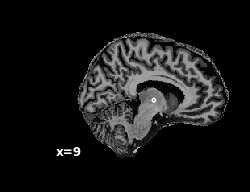

In [312]:
import matplotlib.gridspec as gridspec
# gs = gridspec.GridSpec(3, 6)

# Location in brain
#cut_coords = find_xyz_cut_coords(roi)
#cut_coords = [0, 35, -22]
disp = plotting.plot_anat(anat_img=t1w_template.format(**{'sub':sub_str}), 
                          #axes=plt.subplot(gs[0,0]), 
                          draw_cross=True,
                          cut_coords=[int(cut_coords[0])], display_mode='x')
#                          vmax=15, threshold=4)
add_contours(disp, roi, color='white')
#disp.add_markers(marker_coords=cut_coords)
f = plt.gcf()
f.show()



In [340]:
# weights per echo
t2s_est = s0_t2star_residuals[:,1].mean()
weights_optcomb = tes*np.exp(-np.array(tes)/t2s_est)
weights_optcomb = weights_optcomb/np.sum(weights_optcomb)

#
tsnr_est = np.array(ts).mean(1)/np.array(ts).std(1)
weights_PAID = tsnr_est*tes
weights_PAID = weights_PAID/np.sum(weights_PAID)
weights_PAID

# manually combined optcomb:
ts_comb_opt_man = np.dot(weights_optcomb, np.array(ts))
ts_comb_paid_man = np.dot(weights_PAID, np.array(ts))

np.corrcoef(ts_comb_opt_man, ts_comb_paid_man)

array([[1.        , 0.99565238],
       [0.99565238, 1.        ]])

In [440]:
R2star_est

56.84979310885863

In [460]:
# s0mean = s0_t2star_residuals[:,0].mean()
# s0std = s0_t2star_residuals[:,0].std()
# R2star_est = 1/(s0_t2star_residuals[:,1].mean()*1000)
# delta_R2star = 1#1/(0.001*1000)

In [561]:
1/0.05

20.0

In [592]:
1/s0_t2star_residuals[:,1].mean()

56.84979310885863

In [587]:
R2star_est

17.590213531387064

In [586]:
delta_R2star

100.0

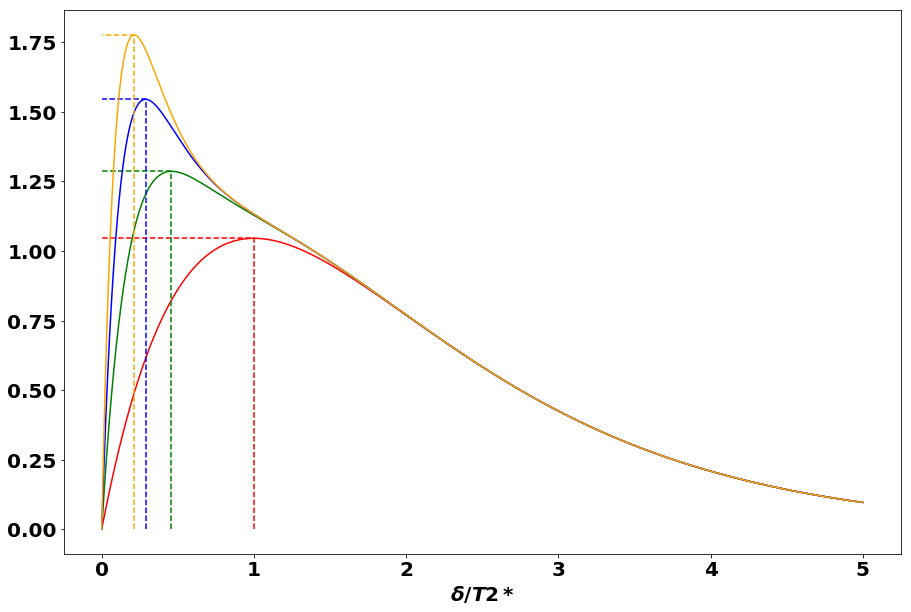

In [588]:
# calculate theoretical CNR
def get_CNR_weighted_sum(s0, ss0, R2star, delta_R2star, delta, n_echos=3):
    """ Eq. 6 in Gowland & Bowtell (2007) """

    echo_n = np.arange(1, n_echos+1)
    two_j_minus_1 = (2*echo_n-1)
    sq = np.sqrt(np.sum(two_j_minus_1**2*np.exp(-2*delta*two_j_minus_1*R2star)))
    
    CNR = (s0 / ss0) * delta_R2star * delta * sq
    return CNR

# get_CNR_weighted_sum(1, 1, 1, 1, 2)

s0mean = 50#s0_t2star_residuals[:,0].mean()
s0std = 1#s0_t2star_residuals[:,0].std()
R2star_est = 1/(s0_t2star_residuals[:,1].mean()*1000
delta_R2star = 1

deltas = np.arange(0, 5, .001)
# x here is *delta*, so TE1
colors = ['red', 'green', 'blue', 'orange']
for n_echos in [1,2,3,4]:
    CNRs = np.empty_like(deltas)
    for i, delta in enumerate(deltas):
        CNRs[i] = get_CNR_weighted_sum(1, 1, 1, 1, delta, n_echos=n_echos)
    
    CNRs = CNRs*(s0mean*delta_R2star) / (s0std*R2star_est)
    # find peak value
    absdiff = np.abs(np.diff(CNRs))
    opt_x = deltas[np.argmin(absdiff)]
    opt_y = CNRs[np.argmin(absdiff)]
    
    plt.plot([opt_x, opt_x, 0], [0, opt_y, opt_y], color=colors[n_echos-1], linestyle='--')
    plt.plot(deltas, CNRs, color=colors[n_echos-1])
    
plt.xlabel('$\delta/T2*$')
# plt.xlim(0.3, 2)
# plt.ylim(0, .001)
plt.gcf().set_size_inches(15,10)

In [553]:
def exp_decay(s0, te, t2s):
    return s0*np.exp(-te/t2s)

diff_manual = exp_decay(1, 15, 15)-exp_decay(1, 15, 14.9)
diff_manual

0.0024607228423362826

In [573]:
.37*(1000*0.001/0.15)

2.466666666666667

In [504]:
def exp_decay_diff(s0, te, t2s, delta_te):
    return s0*(te/t2s)*np.exp(-te/t2s)*(delta_te/t2s)

exp_decay_diff(1, 15, 15, 1)
#diff_eq = 1*(2)/15
#diff_eq*np.exp(-1)

0.024525296078096157

0.015


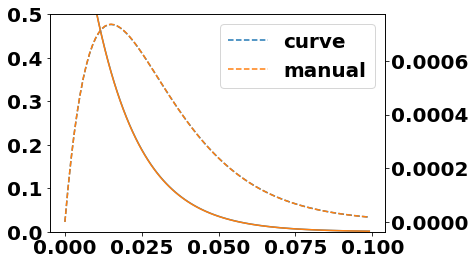

In [537]:
t2s = 0.015
delta_t2s = t2s*0.002
tes = np.arange(0, 0.1, .001)
plt.plot(tes, exp_decay(1, tes, t2s), label='baseline')
plt.plot(tes, exp_decay(1, tes, t2s-delta_t2s), label='active')
plt.ylim(0, .50)
ax1 = plt.twinx()
ax1.plot(tes, exp_decay_diff(1, tes, t2s, delta_t2s), label='curve', linestyle='--')
ax1.plot(tes, exp_decay(1, tes, t2s)-exp_decay(1, tes, t2s-delta_t2s), label='manual', linestyle='--')
#plt.plot(tes, exp_decay_diff(1, tes, 15, 1))
ax1.legend()

manual_diff = exp_decay(1, tes, t2s)-exp_decay(1, tes, t2s-delta_t2s)
manual_diff_diff = np.diff(manual_diff)
min_idx = np.argmax(manual_diff)
print(tes[min_idx])

<>:26: DeprecationWarning: invalid escape sequence \s
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


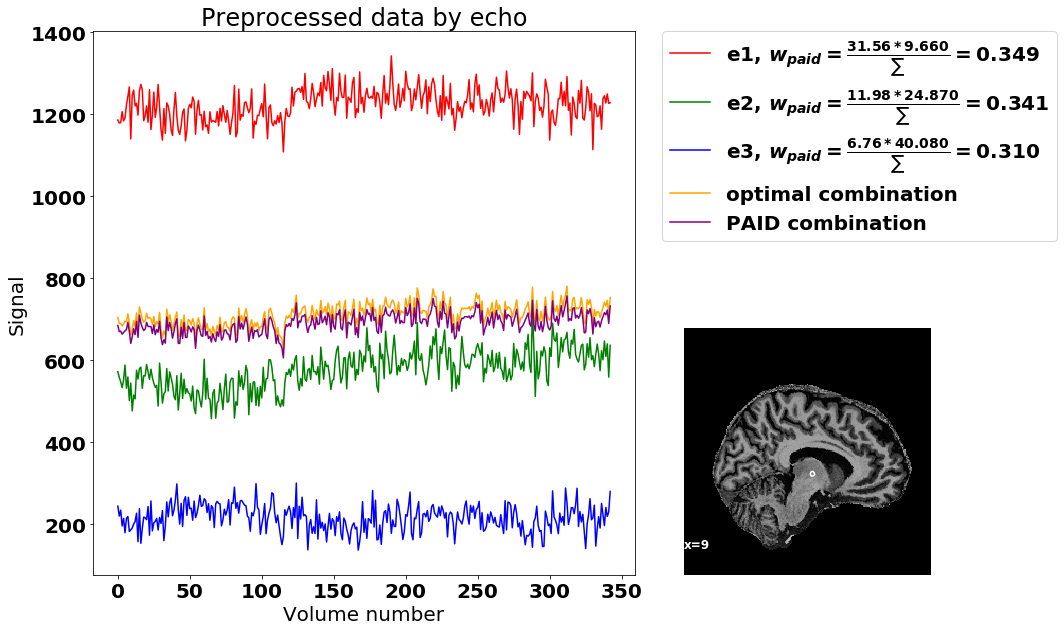

In [342]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

for plot_n in range(3):
    f = plt.Figure()
    gs = gridspec.GridSpec(2, 3)

    disp = plotting.plot_anat(anat_img=t1w_template.format(**{'sub':sub_str}), 
                              axes=plt.subplot(gs[1,-1]), 
                              draw_cross=True,
                              cut_coords=[int(cut_coords[0])], display_mode='x')
    #                          vmax=15, threshold=4)
    add_contours(disp, roi, color='white')


    # Signal per echo
    ax0 = plt.subplot(gs[:,:2])
    if plot_n == 0:
        labels = ['e%d'%(x+1) for x in [0,1,2]]
    elif plot_n == 1:
        labels = ['e%d, $w_{opt}=\\frac{%.2f*e^{\\frac{-%.2f}{%.2f}}}{\sum}=%.3f$'%(x+1, tes[x]*1e3, tes[x]*1e3, t2s_est*1e3, weights_optcomb[x]) for x in [0,1,2]]
    elif plot_n == 2:
        labels = ['e%d, $w_{paid}=\\frac{%.2f*%.3f}{\sum}=%.3f$'%(x+1, tsnr_est[x], tes[x]*1e3, weights_PAID[x]) for x in [0,1,2]]
    ax0.plot(ts[0], color='red', label=labels[0])
    ax0.plot(ts[1], color='green', label=labels[1])
    ax0.plot(ts[2], color='blue', label=labels[2])
    ax0.legend(bbox_to_anchor=(1.05, 1),
               loc=2,
               borderaxespad=0.)
    if plot_n > 0:
        ax0.plot(ts_comb_opt_man, color='orange', label='optimal combination')
    if plot_n > 1:
        ax0.plot(ts_comb_paid_man, color='purple', label='PAID combination')
    ax0.legend(bbox_to_anchor=(1.05, 1),
               loc=2,
               borderaxespad=0.)

    ax0.set_title('Preprocessed data by echo')
    ax0.set_ylabel('Signal')
    ax0.set_xlabel('Volume number')

    # # Decay parameters
    # gs.update(hspace=0.05, wspace=0.2)
    # # s0
    # ax1 = plt.subplot(gs[0,1])
    # ax1.plot(s0_t2star_residuals[:,0])
    # ax1.set_title('Decay parameters over time')
    # ax1.yaxis.tick_right()
    # ax1.tick_params(
    #     axis='x',          # changes apply to the x-axis
    #     which='both',      # both major and minor ticks are affected
    #     labelbottom=False)
    # ax1.set_ylabel('s0')
    # # t2s
    # ax2 = plt.subplot(gs[1,1])
    # ax2.plot(s0_t2star_residuals[:,1])
    # ax2.yaxis.tick_right()
    # ax2.set_ylabel('T2*')
    # ax2.set_xlabel('Volume number')


    f = plt.gcf()
    #f.tight_layout()
    f.set_size_inches(15,10)
    f.savefig('echo_combination_STN_R_%d.png'%(plot_n), bbox_inches='tight')

<>:26: DeprecationWarning: invalid escape sequence \s
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


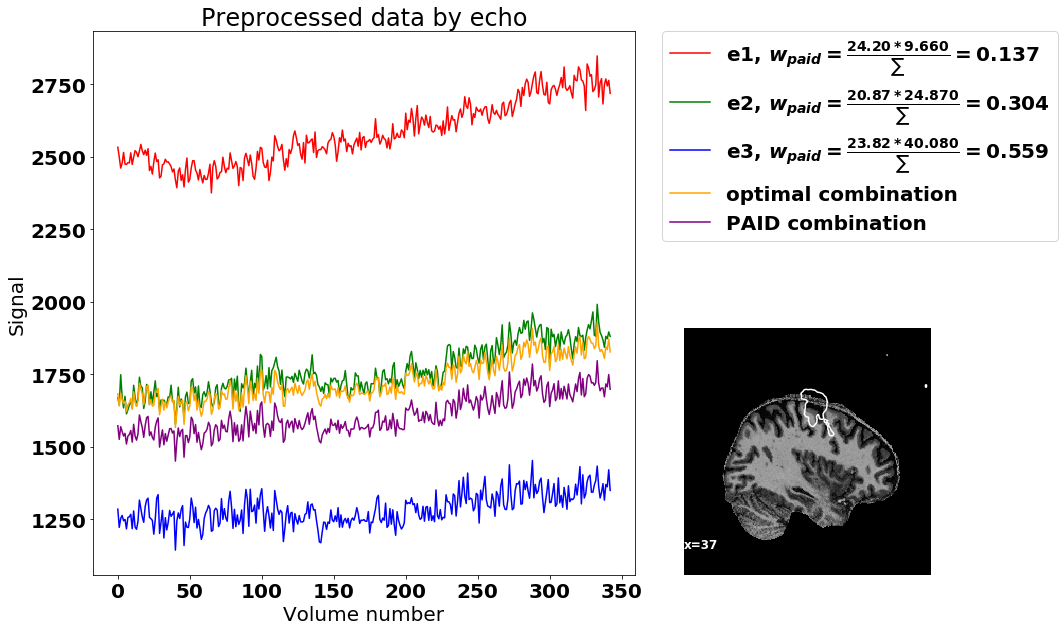

In [334]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

for plot_n in range(3):
    f = plt.Figure()
    gs = gridspec.GridSpec(2, 3)

    disp = plotting.plot_anat(anat_img=t1w_template.format(**{'sub':sub_str}), 
                              axes=plt.subplot(gs[1,-1]), 
                              draw_cross=True,
                              cut_coords=[int(cut_coords[0])], display_mode='x')
    #                          vmax=15, threshold=4)
    add_contours(disp, roi, color='white')


    # Signal per echo
    ax0 = plt.subplot(gs[:,:2])
    if plot_n == 0:
        labels = ['e%d'%(x+1) for x in [0,1,2]]
    elif plot_n == 1:
        labels = ['e%d, $w_{opt}=\\frac{%.2f*e^{\\frac{-%.2f}{%.2f}}}{\sum}=%.3f$'%(x+1, tes[x]*1e3, tes[x]*1e3, t2s_est*1e3, weights_optcomb[x]) for x in [0,1,2]]
    elif plot_n == 2:
        labels = ['e%d, $w_{paid}=\\frac{%.2f*%.3f}{\sum}=%.3f$'%(x+1, tsnr_est[x], tes[x]*1e3, weights_PAID[x]) for x in [0,1,2]]
    ax0.plot(ts[0], color='red', label=labels[0])
    ax0.plot(ts[1], color='green', label=labels[1])
    ax0.plot(ts[2], color='blue', label=labels[2])
    ax0.legend(bbox_to_anchor=(1.05, 1),
               loc=2,
               borderaxespad=0.)
    if plot_n > 0:
        ax0.plot(ts_comb_opt_man, color='orange', label='optimal combination')
    if plot_n > 1:
        ax0.plot(ts_comb_paid_man, color='purple', label='PAID combination')
    ax0.legend(bbox_to_anchor=(1.05, 1),
               loc=2,
               borderaxespad=0.)

    ax0.set_title('Preprocessed data by echo')
    ax0.set_ylabel('Signal')
    ax0.set_xlabel('Volume number')

    # # Decay parameters
    # gs.update(hspace=0.05, wspace=0.2)
    # # s0
    # ax1 = plt.subplot(gs[0,1])
    # ax1.plot(s0_t2star_residuals[:,0])
    # ax1.set_title('Decay parameters over time')
    # ax1.yaxis.tick_right()
    # ax1.tick_params(
    #     axis='x',          # changes apply to the x-axis
    #     which='both',      # both major and minor ticks are affected
    #     labelbottom=False)
    # ax1.set_ylabel('s0')
    # # t2s
    # ax2 = plt.subplot(gs[1,1])
    # ax2.plot(s0_t2star_residuals[:,1])
    # ax2.yaxis.tick_right()
    # ax2.set_ylabel('T2*')
    # ax2.set_xlabel('Volume number')


    f = plt.gcf()
    #f.tight_layout()
    f.set_size_inches(15,10)
    f.savefig('echo_combination_M1_R_%d.png'%(plot_n), bbox_inches='tight')

### Interestingly, the estimated t2star of this voxel is about 25ms... which is really weird, because it should be around 14ms?

/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


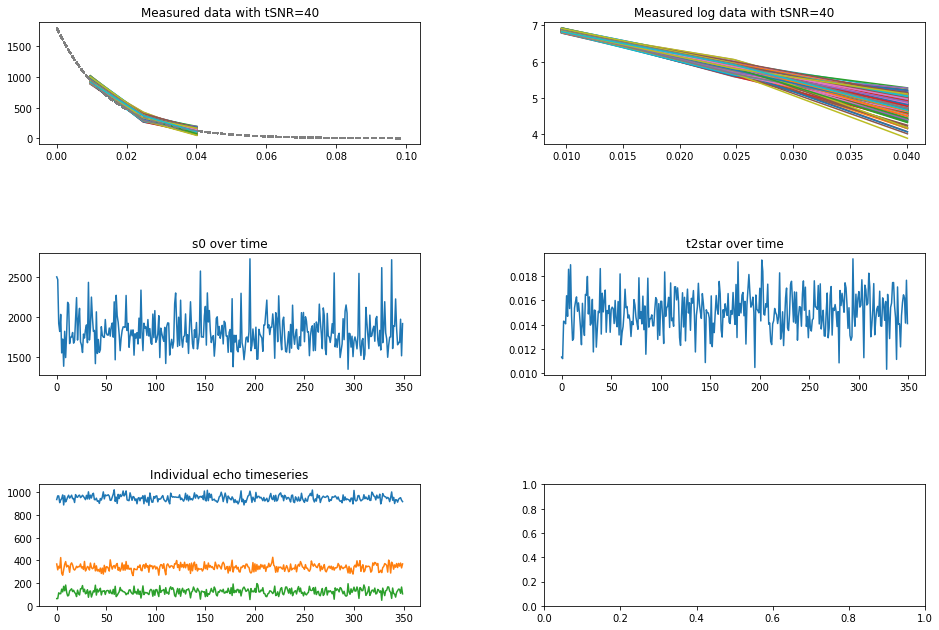

In [105]:
### ehh.. any stinking maths somewhere?
import pandas as pd

def decay_f(x, s0, t2s):
    return s0*np.exp(-x/t2s)

t2s = 0.015
s0 = 1.8e3
xs = np.array([0.0096, 0.02478, 0.04008])
tsnr = 35  # tSNR assumed

f, ax = plt.subplots(3,2)
n_volumes = 350
parameters_fitted = []#pd.DataFrame(columns=['s0', 't2star', 'residuals'], index=[0])
measured_timeseries = []

for volume in range(n_volumes):
    signal = decay_f(xs, s0, t2s)
    noise = np.random.normal(loc=0, scale=signal[0]/tsnr, size=xs.shape[0])
    measured_data = signal+noise
    measured_timeseries.append(pd.DataFrame({'e1': measured_data[0], 'e2': measured_data[1], 'e3': measured_data[2]}, index=[0]))
    
    ax[0,0].plot(xs, measured_data)
    ax[0,0].plot(np.arange(0, .1, .001), decay_f(np.arange(0, .1, .001), s0, t2s), '--', color='grey', alpha=.5)
    ax[0,1].plot(xs, np.log(measured_data))

    # a = (n_samples, 2); column 1 is intercept, columns 2 is time
    a = np.ones((xs.shape[0], 2))
    a[:,1] = -xs

    # b = log of data
    b = np.log(measured_data)
    fit = np.linalg.lstsq(a, b)
    parameters_fitted.append(pd.DataFrame({'s0': np.exp(fit[0][0]), 't2star': 1/fit[0][1], 'res': fit[1]}))
#    print('s0: %.3f, t2s: %.3f' %(np.exp(params_fitted[0]), 1/params_fitted[1]))

all_params = pd.concat(parameters_fitted)
ax[1,0].plot(np.arange(all_params.shape[0]), all_params['s0'])
ax[1,1].plot(np.arange(all_params.shape[0]), all_params['t2star'])
#ax[1,0].plot(all_params['res'])

ax[0,0].set_title('Measured data with tSNR=%d'%tsnr)
ax[0,1].set_title('Measured log data with tSNR=%d'%tsnr)

ax[1,0].set_title('s0 over time')
ax[1,1].set_title('t2star over time')

measured_timeseries = pd.concat(measured_timeseries)
ax[2,0].plot(measured_timeseries['e1'].values)
ax[2,0].plot(measured_timeseries['e2'].values)
ax[2,0].plot(measured_timeseries['e3'].values)
ax[2,0].set_title('Individual echo timeseries')

f.tight_layout()
f.set_size_inches(15,10)
# seems fine

### OK, so the maths seem fine. Let's highpass the real data, and inspect the same voxel
Note that even with a pretty low tSNR you can get very reasonable estimates of t2star. That's nice

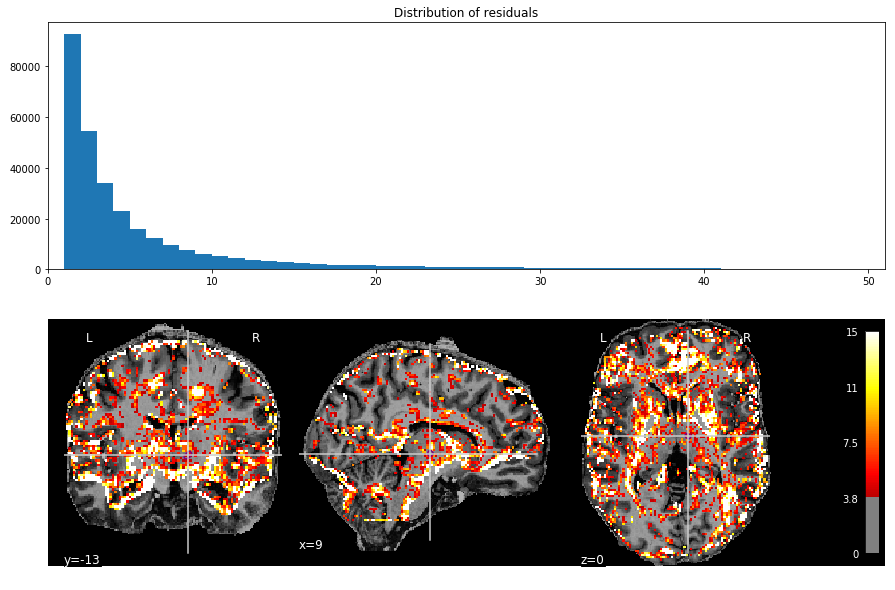

In [112]:
sub = 2
sub_str = str(sub).zfill(2)
run = 1
hp = True
residuals_template = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_residualsvG_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc{hp}.nii.gz'
t1w_template = './data/deriv/fmriprep/sub-{sub}/anat/sub-{sub}_T1w_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'
# def make_median_img(hdr):
#     if isinstance(hdr, str):
#         hdr = nib.load(hdr)
#     dat = np.median(hdr.get_data(), axis=3)
#     return nib.Nifti1Image(dat, hdr.affine)

# median_residuals = make_median_img(residuals_template.format(**{'sub': sub_str, 'run': run}))
median_residuals = nib.load(residuals_template.format(**{'sub': sub_str, 'run': run, 'hp': '_hp' if hp else ''}))
f, ax = plt.subplots(2,1)
ax[0].hist(median_residuals.get_data().ravel(), bins=np.arange(1,51))
ax[0].set_xlim(0, 51)
ax[0].set_title('Distribution of residuals')

#cut_coords = find_xyz_cut_coords(roi)
disp = plotting.plot_stat_map(median_residuals, bg_img=t1w_template.format(**{'sub':sub_str}), 
                              axes=ax[1], draw_cross=True, cut_coords=cut_coords,
                              vmax=15, threshold=4)
add_contours(disp, roi, color='purple')
plt.gcf().set_size_inches(15, 10)

### Where did orbitofrontal cortex go?
Well, it disappeared, because the last echo has no signal. As a result, you're fitting a line between two points, which always works: you overfit massively, leading to *no residuals*

In [113]:
# find STN_R center of mass in matrix
from nibabel.affines import apply_affine
from numpy.linalg import pinv
cut_coords_matrix_space = apply_affine(pinv(median_residuals.affine), cut_coords).astype(int)
echo_template = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_echo-{echo}_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc{hp}.nii.gz'

echo_fns = [echo_template.format(**{'sub': str(sub).zfill(2), 'run': run, 'echo': x, 'hp': '_hp' if hp else ''}) for x in [1,2,3]]
# extract timeseries...
ts = [nib.load(echo_fns[x]).get_data()[cut_coords_matrix_space[0],cut_coords_matrix_space[1],cut_coords_matrix_space[2],:] for x in range(3)]
ts_optcomb = nib.load(echo_fns[0].replace('echo-1', 'optcomb')).get_data()[cut_coords_matrix_space[0],cut_coords_matrix_space[1],cut_coords_matrix_space[2],:]

In [114]:
s0_t2star_residuals = np.empty((ts[0].shape[-1], 3))
for vol in np.arange(ts[0].shape[-1]):
    s0_t2star_residuals[vol,...] = fit_decay_simple(data = np.hstack([ts])[np.newaxis,:,vol,np.newaxis], tes=tes)

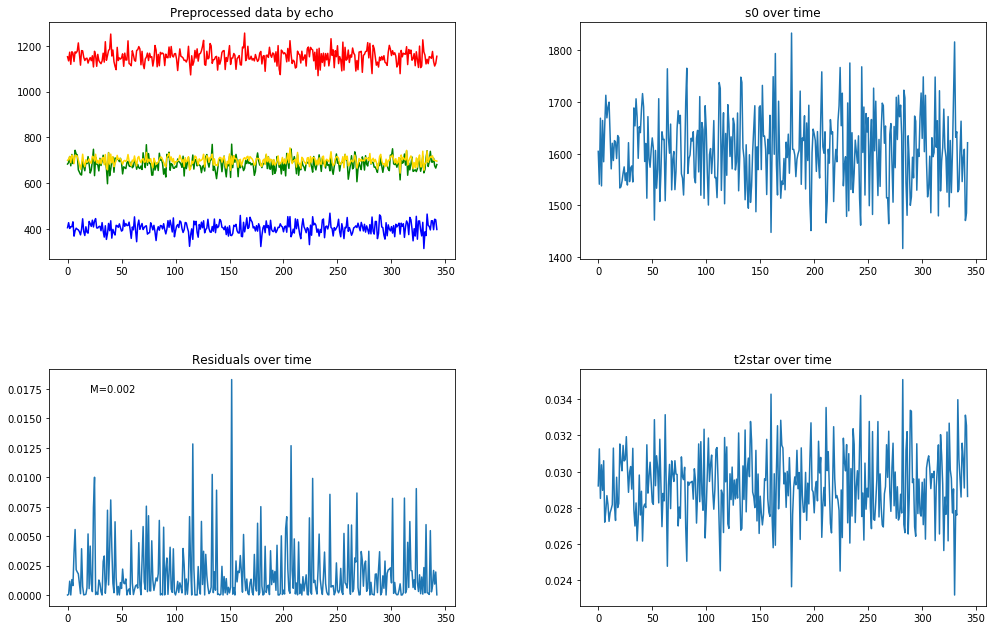

In [115]:
f, ax = plt.subplots(2,2)
ax[0,0].plot(ts[0], color='red')
ax[0,0].plot(ts[1], color='green')
ax[0,0].plot(ts[2], color='blue')
ax[0,0].plot(ts_optcomb, color='gold')
ax[0,0].set_title('Preprocessed data by echo')

ax[1,0].plot(s0_t2star_residuals[:,-1])
ax[1,0].set_title('Residuals over time')
ax[1,0].text(0.1, 0.9, 'M=%.3f' %s0_t2star_residuals[:,-1].mean(), transform=ax[1,0].transAxes)

ax[0,1].plot(s0_t2star_residuals[:,0])
ax[0,1].set_title('s0 over time')

ax[1,1].plot(s0_t2star_residuals[:,1])
ax[1,1].set_title('t2star over time')
f.tight_layout()
f.set_size_inches(15,10)

### So why is the optimally combined signal identical to the first echo signal? (I'm talking about OFC, not STN)
This is because the t2star estimates are *extremely short* (~4ms). As a consequence, only the first echo is really weighted in the procedure. But this is OK (I think)
Note though that the residuals are high (>7) - even after highpassing? (huh? how can this be?)


What about the t2starmap?

In [ ]:
!ls ./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_t2svG_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_hp.nii.gz

0.029096148736871528


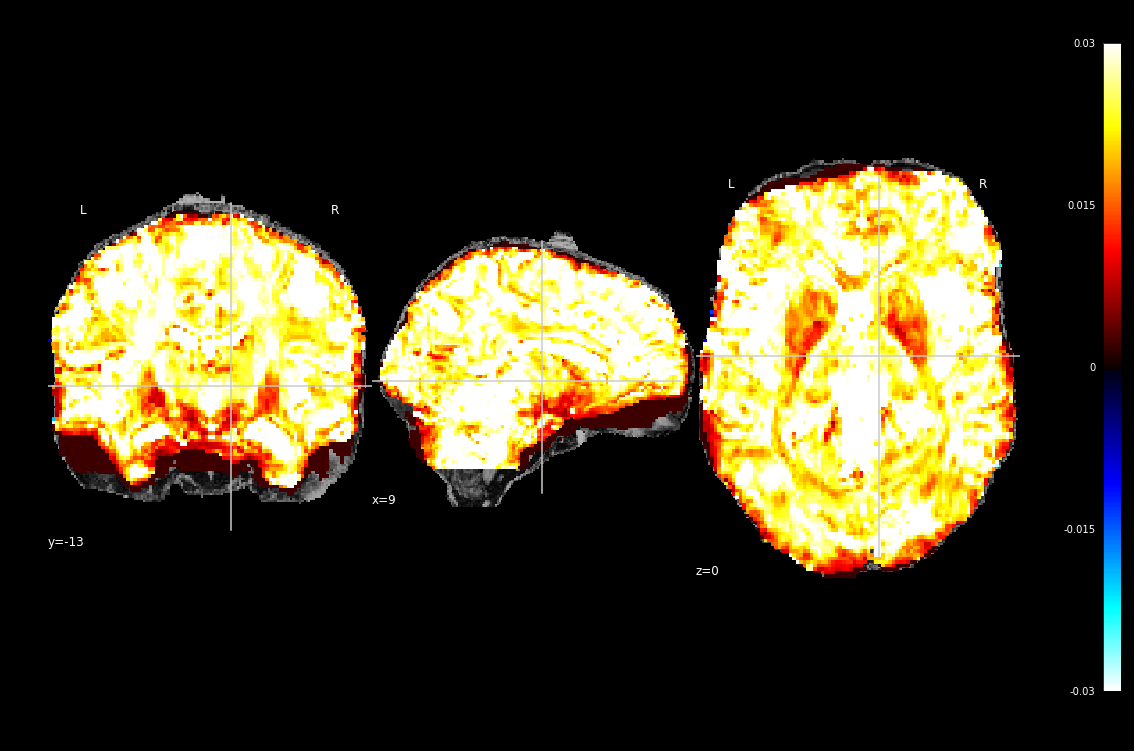

In [117]:
t2starmap_template = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_t2svG_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc{hp}.nii.gz'
t2starmap_fn = t2starmap_template.format(**{'sub': sub_str, 'run': run, 'hp': '_hp' if hp else ''})
plotting.plot_stat_map(t2starmap_fn, bg_img=t1w_template.format(**{'sub':sub_str}), vmax=0.030, cut_coords=cut_coords)
plt.gcf().set_size_inches(15,10)

print(nib.load(t2starmap_fn).get_data()[cut_coords_matrix_space[0], cut_coords_matrix_space[1], cut_coords_matrix_space[2]])

In [119]:
### Let's do this a bit more structural: of all participants, extract the estimated T2star at this voxel

In [123]:
t2starmap_template = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_t2svG_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc{hp}.nii.gz'
hp = False
t2stars = []
for sub in np.arange(1,19):
    if sub == 12:
        continue

    t2starmap_fn = t2starmap_template.format(**{'sub': str(sub).zfill(2), 'run': run, 'hp': '_hp' if hp else ''})
#    plotting.plot_stat_map(t2starmap_fn, bg_img=t1w_template.format(**{'sub':sub_str}), vmax=0.030, cut_coords=cut_coords)
#    plt.gcf().set_size_inches(15,10)
    t2stars.append(nib.load(t2starmap_fn).get_data()[cut_coords_matrix_space[0], cut_coords_matrix_space[1], cut_coords_matrix_space[2]])

In [122]:
hp

True

In [124]:
t2stars

[0.02472766109781367,
 0.029003075505018693,
 0.022181907319263578,
 0.023167271904068126,
 0.023573987297741295,
 0.01866534254050261,
 0.026432658268422414,
 0.019440304208308584,
 0.024544861895001494,
 0.020845204901005672,
 0.023858800562910423,
 0.02176153855996165,
 0.02150766250239624,
 0.023297207943749176,
 0.020439495335643293,
 0.02600473520205987,
 0.02247173769312343]

## Let's see where this comes from: It could be a consequence of some preprocessing step somewhere. So is it maybe in the raw data?

In [13]:
t2starmap_raw = nib.load('./data/raw/bids/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_t2svG_bold.nii.gz')
plotting.plot_stat_map(t2starmap_raw, bg_img=None, vmax=100, cut_coords=cut_coords)

NameError: name 'cut_coords' is not defined

In [127]:
!ls ./data/raw/bids/sub-01/ses-me/func


sub-01_ses-me_task-stop_run-1_echo-1_bold.json
sub-01_ses-me_task-stop_run-1_echo-1_bold.nii
sub-01_ses-me_task-stop_run-1_echo-2_bold.json
sub-01_ses-me_task-stop_run-1_echo-2_bold.nii
sub-01_ses-me_task-stop_run-1_echo-3_bold.json
sub-01_ses-me_task-stop_run-1_echo-3_bold.nii
sub-01_ses-me_task-stop_run-1_optcomb_bold.nii.gz
sub-01_ses-me_task-stop_run-1_PAID_bold.nii.gz
sub-01_ses-me_task-stop_run-1_s0v_bold.nii.gz
sub-01_ses-me_task-stop_run-1_s0vG_bold.nii.gz
sub-01_ses-me_task-stop_run-1_s0vs_bold.nii.gz
sub-01_ses-me_task-stop_run-1_t2ss_bold.nii.gz
sub-01_ses-me_task-stop_run-1_t2sv_bold.nii.gz
sub-01_ses-me_task-stop_run-1_t2svG_bold.nii.gz
sub-01_ses-me_task-stop_run-2_echo-1_bold.json
sub-01_ses-me_task-stop_run-2_echo-1_bold.nii
sub-01_ses-me_task-stop_run-2_echo-2_bold.json
sub-01_ses-me_task-stop_run-2_echo-2_bold.nii
sub-01_ses-me_task-stop_run-2_echo-3_bold.json
sub-01_ses-me_task-stop_run-2_echo-3_bold.nii
sub-01_ses-me_task-stop_run-3_echo-1_bold.json
sub-01_ses-me_ta

In [28]:
np.percentile(median_residuals.get_data().ravel(), 95)

34.0075045026673

In [6]:
def highpass_img(fn, hp=1/128., mask=None):
    """ Function used to apply highpass filter """
    if isinstance(fn, str):
        hdr = nib.load(fn)
    else:
        print('Please provide a filename (not a header)')
        return 1
    
    masker = NiftiMasker(mask_img=mask)
    X = masker.fit_transform(hdr)

    t_r = 3.
    X_filtered = butterworth(signals=X, sampling_rate=1./t_r, high_pass=hp, copy=True)  # HP filter at 1/128
    X_filtered = X_filtered + X.mean(0)  # add back mean signal
    fmri_filtered = masker.inverse_transform(X_filtered)
    fmri_filtered.to_filename(fn.replace('.nii.gz', '_hp.nii.gz'))  # save

    return fn.replace('.nii.gz', '_hp.nii.gz')


In [53]:
highpassed_data = inver.get_data() + np.mean(nib.load(os.path.join(bids_root, fn)).get_data(), 3)[:,:,:,np.newaxis]
highpassed_img = nib.Nifti1Image(highpassed_data, inver.affine)

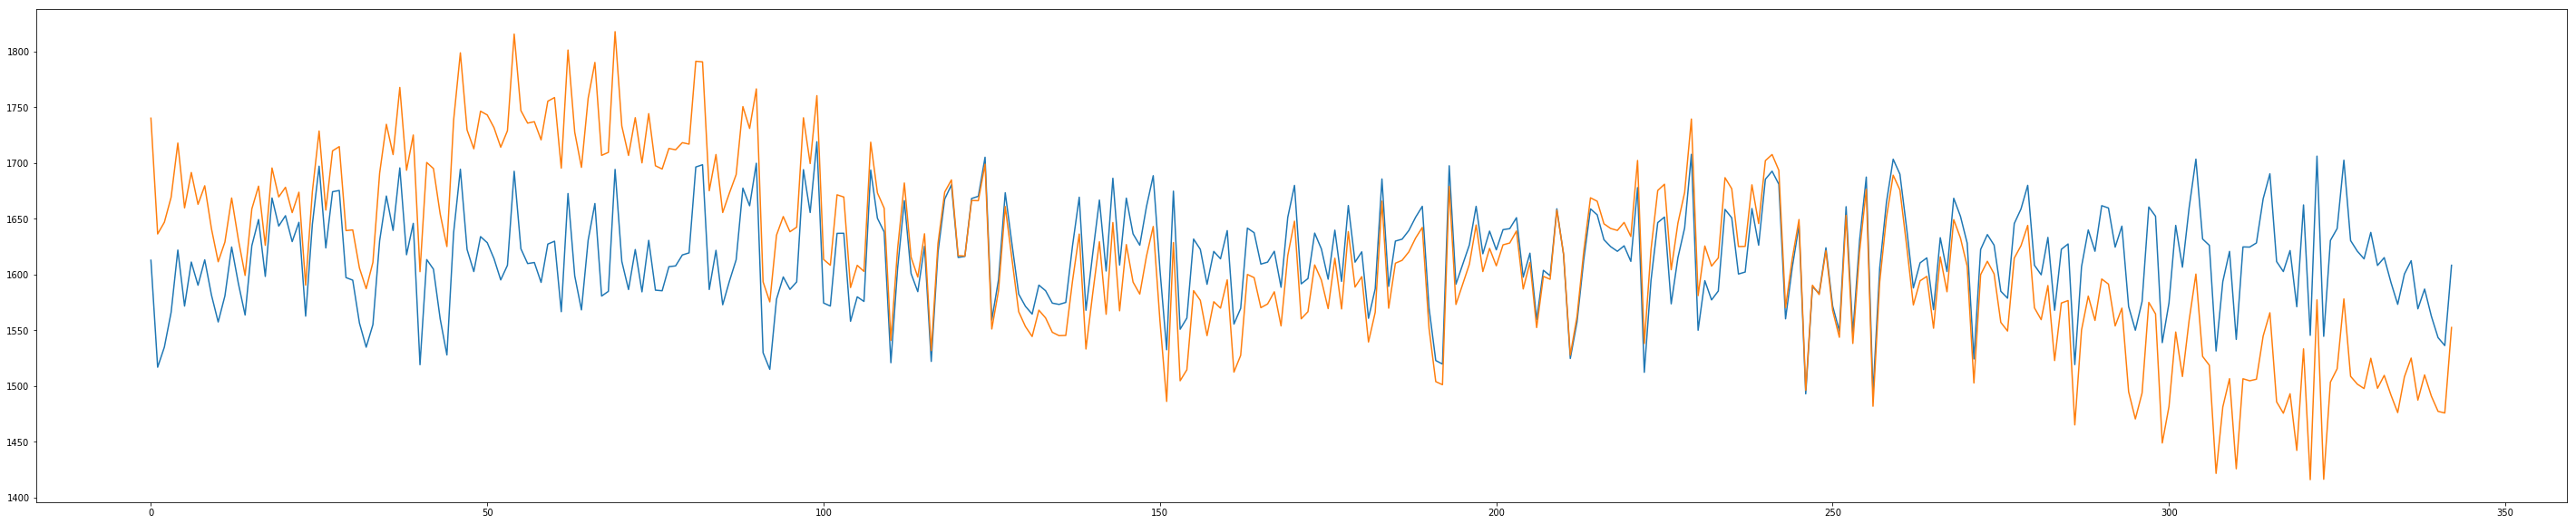

In [54]:
plt.plot(highpassed_data[50,50,50,:])
plt.plot(nib.load(os.path.join(bids_root, fn)).get_data()[50,50,50,:])
plt.gcf().set_size_inches(50,10)

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

space = 'mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm' # or mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm
bids_root = './data/deriv/fmriprep'
me_template = 'sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-%d_echo-%d_bold_space-'+space+'_preproc.nii.gz'# %(sub, sub, run, echo)
me_mask_template = 'sub-%s/ses-me/func/sub-%s_ses-me_task-stop_run-%d_echo-%d_bold_space-'+space+'_brainmask.nii.gz'
se_template = 'sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-%d_bold_space-'+space+'_preproc.nii.gz' # %(sub, sub, run)
se_mask_template = 'sub-%s/ses-se/func/sub-%s_ses-se_task-stop_run-%d_bold_space-'+space+'_brainmask.nii.gz'

for sub in range(1, 19):
    print('\nSubject %d, '%sub, end='')
    sub = str(sub).zfill(2)
    
    for run in [1,2,3]:
        # SE first
        print('run %d, se...' %run, end='')
        fn = os.path.join(bids_root, se_template %(sub,sub,run))
        mask = os.path.join(bids_root, se_mask_template %(sub,sub,run))
        if not os.path.exists(fn.replace('.nii.gz', '_hp.nii.gz')):
            _ = highpass_img(fn, mask=mask, hp=1/128.)
        
        if sub == '12':
            continue

        for echo in [1,2,3]:
           
            print(' me echo %d...' %echo, end='')
            # ME here
            fn = os.path.join(bids_root, me_template %(sub,sub,run,echo))
            mask = os.path.join(bids_root, me_mask_template %(sub,sub,run,echo))
            if not os.path.exists(fn.replace('.nii.gz', '_hp.nii.gz')):
                _ = highpass_img(fn, mask=mask, hp=1/128.)


Subject 1,  me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3...
Subject 2,  me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3...
Subject 3,  me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3...
Subject 4,  me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3...
Subject 5,  me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3...
Subject 6,  me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3... me echo 1... me echo 2... me echo 3...
Subject 7,  me echo 1...

KeyboardInterrupt: 

In [ ]:
import scipy as sp
mask_data = nib.load('masks/final_masks_mni09a_1p6mm/STN_L_def-img.nii.gz').get_data()
com_stn_L = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]
mask_data = nib.load('masks/final_masks_mni09a_1p6mm/STN_R_def-img.nii.gz').get_data()
com_stn_R = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]

mask_data = nib.load('masks/final_masks_mni09a_1p6mm/STR_L_def-img.nii.gz').get_data()
com_str_L = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]
mask_data = nib.load('masks/final_masks_mni09a_1p6mm/STR_R_def-img.nii.gz').get_data()
com_str_R = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]


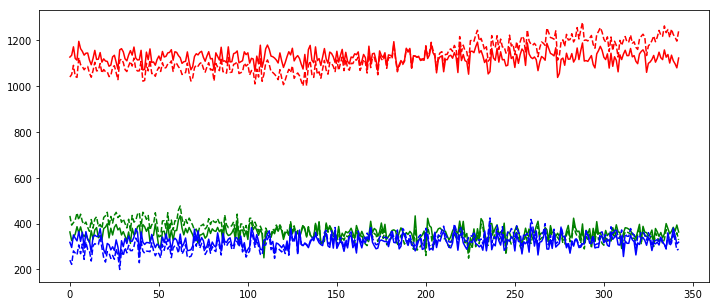

In [48]:
run = 1
cols = ['', 'r', 'g', 'b']
for echo in [1,2,3]:
    fn = './data/deriv/fmriprep/sub-%s/ses-%s/func/sub-%s_ses-%s_task-stop_run-%d_echo-%d_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz' %(sub, ses, sub, ses, run, echo)

    undetrended_hdr = nib.load(fn)
    detrended_hdr = nib.load(fn.replace('.nii.gz', '_hp.nii.gz'))
    plt.plot(detrended_hdr.get_data()[com_stn_L[0], com_stn_L[1], com_stn_L[2],:], color=cols[echo])
    plt.plot(undetrended_hdr.get_data()[com_stn_L[0], com_stn_L[1], com_stn_L[2],:], linestyle='--', color=cols[echo])
    plt.gcf().set_size_inches(12,5)

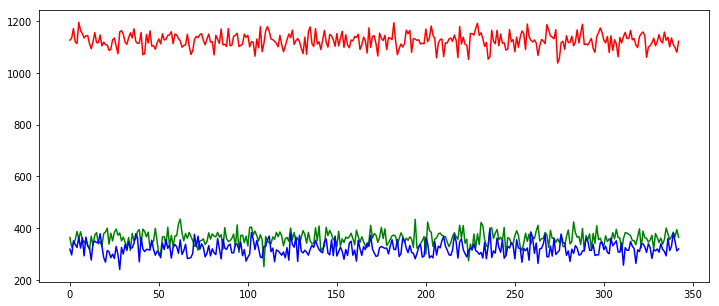

In [49]:
run = 1
cols = ['', 'r', 'g', 'b']
for echo in [1,2,3]:
    fn = './data/deriv/fmriprep/sub-%s/ses-%s/func/sub-%s_ses-%s_task-stop_run-%d_echo-%d_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz' %(sub, ses, sub, ses, run, echo)

    undetrended_hdr = nib.load(fn)
    detrended_hdr = nib.load(fn.replace('.nii.gz', '_hp.nii.gz'))
    plt.plot(detrended_hdr.get_data()[com_stn_L[0], com_stn_L[1], com_stn_L[2],:], color=cols[echo])
#    plt.plot(undetrended_hdr.get_data()[com_stn_L[0], com_stn_L[1], com_stn_L[2],:], linestyle='--', color=cols[echo])
    plt.gcf().set_size_inches(12,5)

/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


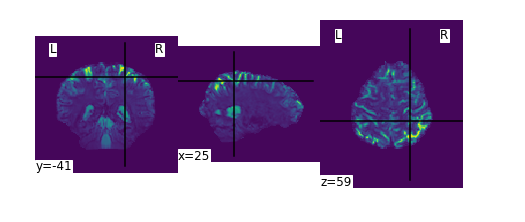

In [45]:
def mean_img(img, axis=3):
    dat = np.mean(img.get_data(), axis=axis)
    img_out = nib.Nifti1Image(dat, img.affine)
    return img_out
    
plotting.plot_img(mean_img(detrended_hdr))